[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/078_adv2d/078_adv2d.ipynb)

## Ecuación de Convección 2D

En el anterior post sobre *PBDL* vimos un primer ejemplo de resolución de ecuación de conservación con métodos numéricos y con redes neuronales. En este post vamos a entrar un poco más en detalle, resolviendo la misma ecuación pero en dos dimensiones.

$$
\phi_t + u \phi_x + v \phi_y = 0
$$

## Método de Volúmenes Finitos

Vamos a resolver la ecuación, primero con el uso de volúmenes finitos.

In [150]:
import numpy as np
import math 

# condición inicial

Lx, Ly, Nx, Ny = 1., 1., 20, 20
dx, dy = Lx / Nx, Ly / Ny

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)

p0 = np.zeros((Ny,Nx))
for i in range(Ny):
    for j in range(Nx):
        p0[i,j] = np.sin(2.*math.pi*x[j])*np.sin(2.*math.pi*y[i])

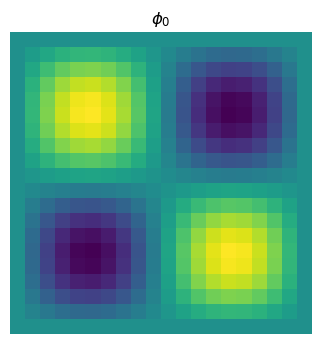

In [151]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.imshow(p0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('$\phi_0$')
ax.axis('off')
plt.show()

De la misma manera que con la ecuación de convección 1D, la versión 2D también tiene solución analítica

$$
\phi(x,y,t) = \phi_0(x - ut, y - vt)
$$

In [152]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update(i):
    ax.clear()
    ax.imshow(ps[i])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f't = {ts[i]:.3f}')
    ax.axis('off')
    return ax

def compute_sol(Ny, Nx, u, v, t):
    p = np.zeros((Ny,Nx))
    for i in range(Ny):
        for j in range(Nx):
            p[i,j] = np.sin(2.*math.pi*(x[j] - u*t))*np.sin(2.*math.pi*(y[i] - v*t))
    return p

u, v = 1, 1
ts = np.linspace(0,1,50)
ps = []
for t in ts:
    p = compute_sol(Ny, Nx, u, v, t)
    ps.append(p)

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim

In [155]:
def compute_flux(p, u, v, scheme='uds'):
    Ny, Nx = p.shape
    fx, fy = np.zeros((Ny,Nx+1)), np.zeros((Ny+1,Nx))
    for i in range(Ny):
        for j in range(Nx+1):
            l, r = j-1, j
            if j == 0:
                l = Nx - 1
            elif j == Nx:
                r = 0
            if scheme == 'uds':
                fx[i,j] = u*p[i,l] if u > 0 else u*p[i,r]
            elif scheme == 'cds':
                fx[i,j] = 0.5*u*(p[i,l] + p[i,r]) 
            else:
                raise 'invalid scheme'
    for i in range(Ny+1):
        for j in range(Nx):
            t, b = i, i-1
            if i == 0:
                b = Ny - 1
            elif i == Ny:
                t = 0
            if scheme == 'uds':
                fy[i,j] = v*p[b,j] if v > 0 else v*p[t,j]
            elif scheme == 'cds':
                fy[i,j] = 0.5*v*(p[b,j] + p[t,j]) 
            else:
                raise 'invalid scheme'
    return fx, fy

def sum_fluxes(fx, fy):
    Ny, Nx = len(fx[0]) - 1, len(fy) - 1
    r = np.zeros((Ny, Nx))
    for i in range(Ny):
        for j in range(Nx):
            r[i,j] = dy*(fx[i,j] - fx[i,j+1]) + dx*v*(fy[i,j] - fy[i+1,j])
    return r

def update_p(p0, r, r0, a, b, h):
    Ny, Nx = p0.shape
    p = np.zeros((Ny, Nx))
    for i in range(Ny):
        for j in range(Nx):
            p[i,j] = p0[i,j] + h*(a*r[i,j] + b*r0[i,j])
    return p

def run_sim(p0, u, v, tf=1., cfl = 1., scheme='uds'):
    ps = [p0]
    pa = [p0]
    ts = [0]
    t = 0
    dt = cfl * min((Lx / Nx) / (abs(u) + 1e-8), (Ly / Ny) / (abs(v) + 1e-8))
    while t + dt < tf:
        t += dt
        h = dt/(dx*dy)
        # euler
        fx, fy = compute_flux(p0, u, v, scheme)
        r = sum_fluxes(fx, fy)
        r0 = np.zeros(r.shape)
        p = update_p(p0, r, r0, 1. , 0., h)
        # second order AB
        fx, fy = compute_flux(p, u, v, scheme)
        r0 = sum_fluxes(fx, fy)
        p2 = update_p(p, r0, r, 1.5, -0.5, h)
        ps.append(p2)
        pa.append(compute_sol(Ny, Nx, u, v, t))
        ts.append(t)
        p0 = p.copy()
    return ps, pa, ts

In [156]:
ps, pa, ts = run_sim(p0, 1., 1., 1., scheme='cds', cfl=0.1)

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim

PASAR A MATRIX MULTIPLY !

## PINNs

In [266]:
import torch
import torch.nn as nn

# PRO TIP: usar `sin` como función de activación :)

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

mlp = nn.Sequential(
    nn.Linear(3, 100),
    Sine(), 
    nn.Linear(100, 100), 
    Sine(), 
    nn.Linear(100, 1)
)

In [267]:
from fastprogress.fastprogress import master_bar, progress_bar

N_STEPS = 10000
N_SAMPLES = 200
N_SAMPLES_0 = 100

optimizer = torch.optim.Adam(mlp.parameters())
criterion = torch.nn.MSELoss()
mlp.train()
u, v = 1., 1.

mb = progress_bar(range(1, N_STEPS+1))

for step in mb:

    # optimize for PDE
    X = torch.rand((N_SAMPLES, 3), requires_grad=True) # N, (X, Y, T)
    y_hat = mlp(X) # N, P 
    grads, = torch.autograd.grad(y_hat, X, grad_outputs=y_hat.data.new(y_hat.shape).fill_(1), create_graph=True, only_inputs=True)
    dpdx, dpdy, dpdt = grads[:,0], grads[:,1], grads[:,2]
    pde_loss = criterion(dpdt, - u*dpdx - v*dpdy)

    # optimize for initial condition
    x = torch.rand(N_SAMPLES_0)
    y = torch.rand(N_SAMPLES_0)
    p0 = torch.sin(2.*math.pi*x / Lx)*torch.sin(2.*math.pi*y / Ly)
    
    X = torch.stack([  # N0, (X, Y, T = 0)
        x, y,
        torch.zeros(N_SAMPLES_0)
    ], axis=-1)
    y_hat = mlp(X) # N, P0 
    ini_loss = criterion(y_hat, p0.unsqueeze(1))  
    
    # optimize for boundary conditions
    t = torch.rand(N_SAMPLES_0)
    X0 = torch.stack([  
        torch.zeros(N_SAMPLES_0),
        y,
        t
    ], axis=-1)
    y_0 = mlp(X0) 

    X1 = torch.stack([  
        torch.ones(N_SAMPLES_0),
        y,
        t
    ], axis=-1)
    y_1 = mlp(X1)
    bound_loss1 = criterion(y_0, y_1)
    Y0 = torch.stack([  
        x,
        torch.zeros(N_SAMPLES_0),
        t
    ], axis=-1)
    y_0 = mlp(X0) 

    Y1 = torch.stack([  
        x,
        torch.ones(N_SAMPLES_0),
        t
    ], axis=-1)
    y_1 = mlp(X1)
    bound_loss2 = criterion(y_0, y_1)
    bound_loss = bound_loss1 + bound_loss2

    # update
    optimizer.zero_grad()
    loss = pde_loss + ini_loss + bound_loss
    loss.backward()
    optimizer.step()
    
    mb.comment = f'pde_loss {pde_loss.item():.5f} ini_loss {ini_loss.item():.5f} bound_loss {bound_loss.item():.5f}'


In [272]:
def run_mlp(Nx, Ny, dt, u, v):
    ps, pa, ts = [], [], []
    t = 0
    L = 1.
    dx, dy = L / Nx, L / Ny
    x, y = [], []
    for i in range(Ny+1):
        for j in range(Nx+1):
            x.append(j*dx)
            y.append(i*dy)
    x = torch.tensor(x)
    y = torch.tensor(y)
    mlp.eval()
    while t < 1.:
        with torch.no_grad():
            X = torch.stack([  # N, (X, Y, T)
                x, y,
                torch.ones(len(x))*t,
            ], axis=-1)
            p = mlp(X)
        ps.append(p.reshape(Ny+1,Nx+1))
        pa.append(compute_sol(Ny, Nx, u, v, t))
        ts.append(t)
        t += dt
    return ps, pa, ts

In [273]:
ps, pa, ts = run_mlp(33, 33, 0.01, u, v)

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim